In [1]:
import colbert.warp.setup

from colbert.warp.config import WARPRunConfig
from colbert.warp.searcher import WARPSearcher
from colbert.warp.data.queries import WARPQueries

from colbert.warp.onnx_model import (
    XTROnnxQuantization,
    XTROnnxConfig,
)

from colbert.utils.tracker import ExecutionTracker

#> Running WARP Setup Code.


In [2]:
onnx_config = XTROnnxConfig(quantization=XTROnnxQuantization.PREPROCESS)
config = WARPRunConfig(
    nranks=4,
    dataset="lotte",
    collection="writing",
    type_="search",
    datasplit="test",
    nbits=4,
    k=100,
    onnx=onnx_config
)
searcher = WARPSearcher(config)
queries = WARPQueries(config)

[Jul 11, 19:46:51] #> Loading collection...
0M 
#> Loading XTR ONNX model from '/Users/jlscheerer/xtr/models/onnx/xtr.v=13.batch=1.PREPROCESS.onnx' (418.79MB)
[Jul 11, 19:46:52] #> Loading buckets...
[Jul 11, 19:46:52] #> Loading codec...
[Jul 11, 19:46:54] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jul 11, 19:46:54] #> Loading repacked residuals...
[Jul 11, 19:46:55] Loading precompute_topk_centroids_cpp extension (set WARP_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jul 11, 19:46:55] Loading decompress_centroid_embeds_strided_repacked_cpp extension (set WARP_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jul 11, 19:46:55] Loading compute_candidate_scores_cpp extension (set WARP_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jul 11, 19:46:55] #> Loading the queries from /Users/jlscheerer/future/datasets/writing/test/questions.search.tsv ...
[Jul 11, 19:46:55] #> Got 1071 queries. All QIDs are unique.



In [5]:
tracker = ExecutionTracker(name="XTR/WARP", steps=["Query Encoding", "Candidate Generation", "top-k Precompute",
                                                   "Decompression", "Lookup", "Build Matrix"])
ranking = searcher.search_all(queries, k=5, batched=False, tracker=tracker)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1071/1071 [00:27<00:00, 38.64it/s]


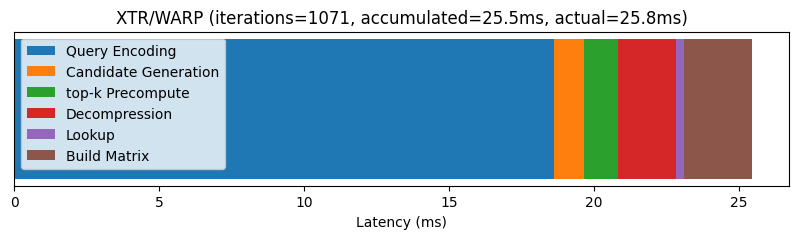

In [6]:
tracker.display()